In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'Date',
       'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-11-30 05:26:13  33.93911   
1   NaN    NaN            NaN        Albania  2020-11-30 05:26:13  41.15330   

       Long_  Confirmed  Deaths  Recovered   Active Combined_Key  \
0  67.709953    46215.0  1763.0    36731.0   7721.0  Afghanistan   
1  20.168300    37625.0   798.0    18481.0  18346.0      Albania   

   Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
0     118.718134             3.814779 2020-11-29             NaN   
1    1307.422337             2.120930 2020-11-29             NaN   

   Case-Fatality_Ratio  
0                  NaN  
1                  NaN

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    8712
unique                    264
top       2020-09-01 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-11-29 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
211            NaN                  NaN 2020-03-12             NaN   
212            NaN

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     264
unique                    264
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-11-29 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     284
unique                    284
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-11-29 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State    Country_Region  \
383       NaN                   NaN                    NaN  Marshall Islands   
367       NaN                   NaN                    NaN              Laos   
367       NaN                   NaN                    NaN              Laos   
214       NaN                   NaN                    NaN            France   
344       NaN                   NaN        Port Quarantine             Japan   
...       ...                   ...                    ...               ...   
3186      NaN                   NaN   Prince Edward Island            Canada   
3187      NaN                   NaN  Northwest Territories            Canada   
3188      NaN                   NaN       Diamond Princess            Canada   
3415  11001.0  District of Columbia   District of Columbia                US   
3416  53023.0       Garfield County             Washington                US   

              Last_Update        Lat       Long_  Confirmed   Deaths  \
383   2020-11-30 05:26:13   7.131500  171.184500        4.0      0.0   
367   2020-11-27 05:26:53  19.856270  102.495496       39.0      0.0   
367   2020-11-26 05:27:44  19.856270  102.495496       25.0      0.0   
214   2020-11-25 05:27:20  46.227600    2.213700  2154097.0  49902.0   
344   2020-11-25 05:27:20        NaN         NaN     1453.0      1.0   
...                   ...        ...         ...        ...      ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0      0.0   
3187        3/22/20 23:48        NaN         NaN        1.0      0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0      1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0      2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0      2.0   

      Recovered     Active                                  Combined_Key  \
383         1.0        0.0                              Marshall Islands   
367        23.0       15.0                                          Laos   
367        23.0       15.0                                          Laos   
214    132720.0  1970680.0                                        France   
344       514.0      139.0                        Port Quarantine, Japan   
...         ...        ...                                           ...   
3186        0.0        0.0                  Prince Edward Island, Canada   
3187        0.0        0.0                 Northwest Territories, Canada   
3188        0.0        0.0                      Diamond Princess, Canada   
3415        0.0        0.0  District of Columbia,District of Columbia,US   
3416        0.0        0.0                 Garfield County,Washington,US   

      Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
383        6.847791             0.000000 2020-11-29             NaN   
367        0.836192             0.000000 2020-11-26             NaN   
367        0.536042             0.000000 2020-11-25             NaN   
214     3298.883320             2.316609 2020-11-24             NaN   
344             NaN             0.068823 2020-11-24             NaN   
...             ...                  ...        ...             ...   
3186            NaN                  NaN 2020-03-22             NaN   
3187            NaN                  NaN 2020-03-22             NaN   
3188            NaN                  NaN 2020-03-22             NaN   
3415            NaN                  NaN 2020-03-22             NaN   
3416            NaN                  NaN 2020-03-22             NaN   

      Case-Fatality_Ratio  
383                   NaN  
367                   NaN  
367                   NaN  
214                   NaN  
344                   NaN  
...                   ...  
3186                  NaN  
3187                  NaN  
3188                  NaN  
3415                  NaN  
3416                  NaN  

[60208 rows x 17 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51114 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            51114 non-null  float64
 1   Deaths               51114 non-null  float64
 2   Recovered            51114 non-null  float64
 3   Active               51114 non-null  float64
 4   Incident_Rate        51114 non-null  float64
 5   Case_Fatality_Ratio  51114 non-null  float64
 6   Incidence_Rate       51114 non-null  float64
 7   Case-Fatality_Ratio  51114 non-null  float64
dtypes: float64(8)
memory usage: 3.3+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region Date                                                             
 Azerbaijan    2020-02-28            0.0                  0.0             0.0   
Afghanistan    2020-02-24            0.0                  0.0             0.0   
               2020-02-25            0.0                  0.0             0.0   
               2020-02-26            0.0                  0.0             0.0   
               2020-02-27            0.0                  0.0             0.0   

                           Case-Fatality_Ratio  
Country_Region Date                             
 Azerbaijan    2020-02-28                  0.0  
Afghanistan    2020-02-24                  0.0  
               2020-02-25                  0.0  
               2020-02-26                  0.0  
               2020-02-27                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'India', 'Brazil', 'France', 'Russia', 'Spain', 'United Kingdom',
       'Italy', 'Argentina', 'Colombia', 'Mexico', 'Germany', 'Poland', 'Peru',
       'Iran', 'South Africa', 'Ukraine', 'Turkey', 'Belgium', 'Iraq', 'Chile',
       'Indonesia', 'Netherlands', 'Czechia', 'Romania', 'Bangladesh',
       'Philippines', 'Pakistan', 'Canada', 'Saudi Arabia', 'Morocco',
       'Israel', 'Switzerland', 'Portugal', 'Austria', 'Sweden', 'Nepal',
       'Jordan', 'Hungary', 'Ecuador', 'Serbia', 'United Arab Emirates',
       'Panama', 'Japan', 'Bolivia', 'Dominican Republic', 'Bulgaria',
       'Kuwait', 'Qatar', 'Costa Rica'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))
print()
print('\n'.join(c for c in population.index if 'Venezuela' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)

Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14117 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-11-29 00:00:00'))
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            14117 non-null  float64
 1   Deaths               14117 non-null  float64
 2   Recovered            14117 non-null  float64
 3   Active               14117 non-null  float64
 4   Incident_Rate        14117 non-null  float64
 5   Case_Fatality_Ratio  14117 non-null  float64
 6   Incidence_Rate       14117 non-null  float64
 7   Case-Fatality_Ratio  14117 non-null  float64
 8   Confirmed_per_100k   14117 non-null  float64
 9   Deaths_per_100k      14117 non-null  float64
 10  Recovered_per_100k   14117 non-null  float64
 11  Active_per_100k      14117 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ MB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region Date                                                             
Argentina      2020-03-03            0.0                  0.0             0.0   
               2020-03-04            0.0                  0.0             0.0   
               2020-03-05            0.0                  0.0             0.0   
               2020-03-06            0.0                  0.0             0.0   
               2020-03-07            0.0                  0.0             0.0   

                           Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region Date                                                  
Argentina      2020-03-03                  0.0            0.002233   
               2020-03-04                  0.0            0.002233   
               2020-03-05                  0.0            0.002233   
               2020-03-06                  0.0            0.004466   
               2020-03-07                  0.0            0.017865   

                           Deaths_per_100k  Recovered_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03              0.0                 0.0   
               2020-03-04              0.0                 0.0   
               2020-03-05              0.0                 0.0   
               2020-03-06              0.0                 0.0   
               2020-03-07              0.0                 0.0   

                           Active_per_100k  
Country_Region Date                         
Argentina      2020-03-03         0.002233  
               2020-03-04         0.002233  
               2020-03-05         0.002233  
               2020-03-06         0.004466  
               2020-03-07         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incident_Rate            50 non-null     float64
 5   Case_Fatality_Ratio      50 non-null     float64
 6   Incidence_Rate           50 non-null     float64
 7   Case-Fatality_Ratio      50 non-null     float64
 8   Confirmed_per_100k       50 non-null     float64
 9   Deaths_per_100k          50 non-null     float64
 10  Recovered_per_100k       50 non-null     float64
 11  Active_per_100k          50 non-null     float64
 12  population               50 non-null     float64
 13  recovered_per_confirmed  50 non-null     float64
 14  deaths_per_co

Confirmed    Deaths  Recovered     Active  \
Country_Region                                                     
Argentina              1418807.0   38473.0  1249843.0   174335.0   
Austria                 279708.0    3105.0   216998.0    77130.0   
Bangladesh              462407.0    6609.0   378172.0   115779.0   
Belgium                 576599.0   16547.0    31130.0   560052.0   
Bolivia                 144622.0    8952.0   121472.0    60928.0   
Brazil                 6314740.0  172833.0  5581436.0   726064.0   
Bulgaria                142486.0    3814.0    48594.0    90219.0   
Canada                  373662.0   12046.0   299095.0    62521.0   
Chile                   550430.0   15356.0   525213.0    95631.0   
Colombia               1308376.0   36584.0  1204452.0   925831.0   
Costa Rica              137093.0    1690.0    84991.0    50790.0   
Czechia                 519723.0    8138.0   444406.0   188492.0   
Dominican Republic      143473.0    2330.0   114818.0    35057.0   
Ecuador                 192117.0   13423.0   169804.0    44283.0   
France                 2256673.0   52221.0   164559.0  2039893.0   
Germany                1055691.0   16306.0   730797.0   317709.0   
Hungary                 211527.0    4672.0    55637.0   151218.0   
India                  9431691.0  137139.0  8847600.0  1017754.0   
Indonesia               534266.0   16815.0   445793.0    71658.0   
Iran                    948749.0   47874.0   658292.0   242583.0   
Iraq                    550435.0   12224.0   480903.0    63157.0   
Israel                  335598.0    2864.0   323067.0    72400.0   
Italy                  1585178.0   54904.0   734503.0   805947.0   
Japan                   147515.0    2057.0   121735.0    24783.0   
Jordan                  214307.0    2694.0   148572.0   137385.0   
Kuwait                  142426.0     878.0   136413.0    15831.0   
Mexico                 1107071.0  105655.0   824355.0   192363.0   
Morocco                 353803.0    5789.0   302314.0    49800.0   
Nepal                   231978.0    1479.0   212590.0    46691.0   
Netherlands             527336.0    9426.0     6921.0   510989.0   
Pakistan                398024.0    8025.0   341423.0   108642.0   
Panama                  164729.0    3060.0   143616.0    25549.0   
Peru                    962530.0   35923.0   893061.0   168092.0   
Philippines             429864.0    8373.0   398624.0    83109.0   
Poland                  985075.0   17029.0   559429.0   440035.0   
Portugal                294799.0    4427.0   209534.0    88854.0   
Qatar                   138648.0     237.0   135862.0    35634.0   
Romania                 471536.0   11193.0   348852.0   120307.0   
Russia                 2249890.0   39127.0  1746279.0   464484.0   
Saudi Arabia            357128.0    5884.0   346409.0    63026.0   
Serbia                  169214.0    1549.0    15564.0   167665.0   
South Africa            787702.0   21477.0   730633.0   173590.0   
Spain                  1628208.0   44668.0   150376.0  1433164.0   
Sweden                  243129.0    6681.0     4971.0   236448.0   
Switzerland             318290.0    4650.0   222100.0   139020.0   
Turkey                  607628.0   13558.0   400242.0   193828.0   
US                    13383320.0  266873.0  5065030.0  8051417.0   
Ukraine                 742105.0   12613.0   354556.0   374936.0   
United Arab Emirates    167753.0     570.0   154185.0    17173.0   
United Kingdom         1621305.0   58342.0     3514.0  1559449.0   

                      Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region                                                             
Argentina              3.139247e+03             2.716769    2.748447e+03   
Austria                3.105658e+03             1.110086    1.700491e+03   
Bangladesh             2.807752e+02             1.443872    2.551701e+02   
Belgium                5.701514e+04           173.685315    4.321015e+03   
Bolivia                1.23894

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                            
US                    13383320.0  266873.0
India                  9431691.0  137139.0
Brazil                 6314740.0  172833.0
France                 2256673.0   52221.0
Russia                 2249890.0   39127.0
Spain                  1628208.0   44668.0
United Kingdom         1621305.0   58342.0
Italy                  1585178.0   54904.0
Argentina              1418807.0   38473.0
Colombia               1308376.0   36584.0
Mexico                 1107071.0  105655.0
Germany                1055691.0   16306.0
Poland                  985075.0   17029.0
Peru                    962530.0   35923.0
Iran                    948749.0   47874.0
South Africa            787702.0   21477.0
Ukraine                 742105.0   12613.0
Turkey                  607628.0   13558.0
Belgium                 576599.0   16547.0
Iraq                    550435.0   12224.0
Chile                   550430.0   15356.0
Indonesia               534266.0   16815.0
Netherlands             527336.0    9426.0
Czechia                 519723.0    8138.0
Romania                 471536.0   11193.0
Bangladesh              462407.0    6609.0
Philippines             429864.0    8373.0
Pakistan                398024.0    8025.0
Canada                  373662.0   12046.0
Saudi Arabia            357128.0    5884.0
Morocco                 353803.0    5789.0
Israel                  335598.0    2864.0
Switzerland             318290.0    4650.0
Portugal                294799.0    4427.0
Austria                 279708.0    3105.0
Sweden                  243129.0    6681.0
Nepal                   231978.0    1479.0
Jordan                  214307.0    2694.0
Hungary                 211527.0    4672.0
Ecuador                 192117.0   13423.0
Serbia                  169214.0    1549.0
United Arab Emirates    167753.0     570.0
Panama                  164729.0    3060.0
Japan                   147515.0    2057.0
Bolivia                 144622.0    8952.0
Dominican Republic      143473.0    2330.0
Bulgaria                142486.0    3814.0
Kuwait                  142426.0     878.0
Qatar                   138648.0     237.0
Costa Rica              137093.0    1690.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k   Confirmed    Deaths
Country_Region                                                
Belgium                      4996.816972    576599.0   16547.0
Qatar                        4895.639975    138648.0     237.0
Czechia                      4862.125958    519723.0    8138.0
US                           4067.075920  13383320.0  266873.0
Israel                       3939.233556    335598.0    2864.0
Panama                       3879.225893    164729.0    3060.0
Switzerland                  3704.768080    318290.0    4650.0
Spain                        3483.782859   1628208.0   44668.0
France                       3464.889176   2256673.0   52221.0
Kuwait                       3385.390855    142426.0     878.0
Argentina                    3168.346614   1418807.0   38473.0
Austria                      3123.446417    279708.0    3105.0
Netherlands                  3084.355187    527336.0    9426.0
Brazil                       2992.065573   6314740.0  172833.0
Peru                         2960.677704    962530.0   35923.0
Chile                        2904.331909    550430.0   15356.0
Portugal                     2882.787685    294799.0    4427.0
Costa Rica                   2716.024631    137093.0    1690.0
Italy                        2617.961340   1585178.0   54904.0
Poland                       2599.981403    985075.0   17029.0
Colombia                     2599.107026   1308376.0   36584.0
Romania                      2435.046542    471536.0   11193.0
Sweden                       2422.474374    243129.0    6681.0
United Kingdom               2400.860558   1621305.0   58342.0
Hungary                      2184.140312    211527.0    4672.0
Jordan                       2121.495032    214307.0    2694.0
Bulgaria                     2035.480264    142486.0    3814.0
Serbia                       1928.974030    169214.0    1549.0
United Arab Emirates         1716.929058    167753.0     570.0
Ukraine                      1686.845984    742105.0   12613.0
Russia                       1542.370016   2249890.0   39127.0
Iraq                         1400.249185    550435.0   12224.0
South Africa                 1345.159344    787702.0   21477.0
Dominican Republic           1336.004977    143473.0    2330.0
Germany                      1264.042552   1055691.0   16306.0
Bolivia                      1256.151470    144622.0    8952.0
Iran                         1144.258176    948749.0   47874.0
Ecuador                      1105.794825    192117.0   13423.0
Saudi Arabia                 1042.145696    357128.0    5884.0
Canada                        998.801477    373662.0   12046.0
Morocco                       970.073673    353803.0    5789.0
Mexico                        867.776923   1107071.0  105655.0
Nepal                         810.864801    231978.0    1479.0
Turkey                        728.312193    607628.0   13558.0
India                         690.249447   9431691.0  137139.0
Philippines                   397.592888    429864.0    8373.0
Bangladesh                    283.604939    462407.0    6609.0
Indonesia                     197.418894    534266.0   16815.0
Pakistan                      183.789355    398024.0    8025.0
Japan                         116.281454    147515.0    2057.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                  
Mexico                 1107071.0  105655.0              0.095437
Ecuador                 192117.0   13423.0              0.069869
Bolivia                 144622.0    8952.0              0.061899
Iran                    948749.0   47874.0              0.050460
Peru                    962530.0   35923.0              0.037321
United Kingdom         1621305.0   58342.0              0.035985
Italy                  1585178.0   54904.0              0.034636
Canada                  373662.0   12046.0              0.032238
Indonesia               534266.0   16815.0              0.031473
Belgium                 576599.0   16547.0              0.028698
Colombia               1308376.0   36584.0              0.027961
Chile                   550430.0   15356.0              0.027898
Sweden                  243129.0    6681.0              0.027479
Spain                  1628208.0   44668.0              0.027434
Brazil                 6314740.0  172833.0              0.027370
South Africa            787702.0   21477.0              0.027265
Argentina              1418807.0   38473.0              0.027116
Bulgaria                142486.0    3814.0              0.026768
Romania                 471536.0   11193.0              0.023737
France                 2256673.0   52221.0              0.023141
Turkey                  607628.0   13558.0              0.022313
Iraq                    550435.0   12224.0              0.022208
Hungary                 211527.0    4672.0              0.022087
Pakistan                398024.0    8025.0              0.020162
US                    13383320.0  266873.0              0.019941
Philippines             429864.0    8373.0              0.019478
Panama                  164729.0    3060.0              0.018576
Netherlands             527336.0    9426.0              0.017875
Russia                 2249890.0   39127.0              0.017391
Poland                  985075.0   17029.0              0.017287
Ukraine                 742105.0   12613.0              0.016996
Saudi Arabia            357128.0    5884.0              0.016476
Morocco                 353803.0    5789.0              0.016362
Dominican Republic      143473.0    2330.0              0.016240
Czechia                 519723.0    8138.0              0.015658
Germany                1055691.0   16306.0              0.015446
Portugal                294799.0    4427.0              0.015017
Switzerland             318290.0    4650.0              0.014609
India                  9431691.0  137139.0              0.014540
Bangladesh              462407.0    6609.0              0.014293
Japan                   147515.0    2057.0              0.013944
Jordan                  214307.0    2694.0              0.012571
Costa Rica              137093.0    1690.0              0.012327
Austria                 279708.0    3105.0              0.011101
Serbia                  169214.0    1549.0              0.009154
Israel                  335598.0    2864.0              0.008534
Nepal                   231978.0    1479.0              0.006376
Kuwait                  142426.0     878.0              0.006165
United Arab Emirates    167753.0     570.0              0.003398
Qatar                   138648.0     237.0              0.001709

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate',
       'Case_Fatality_Ratio', 'Incidence_Rate', 'Case-Fatality_Ratio',
       'Confirmed_per_100k', 'Deaths_per_100k', 'Recovered_per_100k',
       'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

IndexError: index 2 is out of bounds for axis 1 with size 2

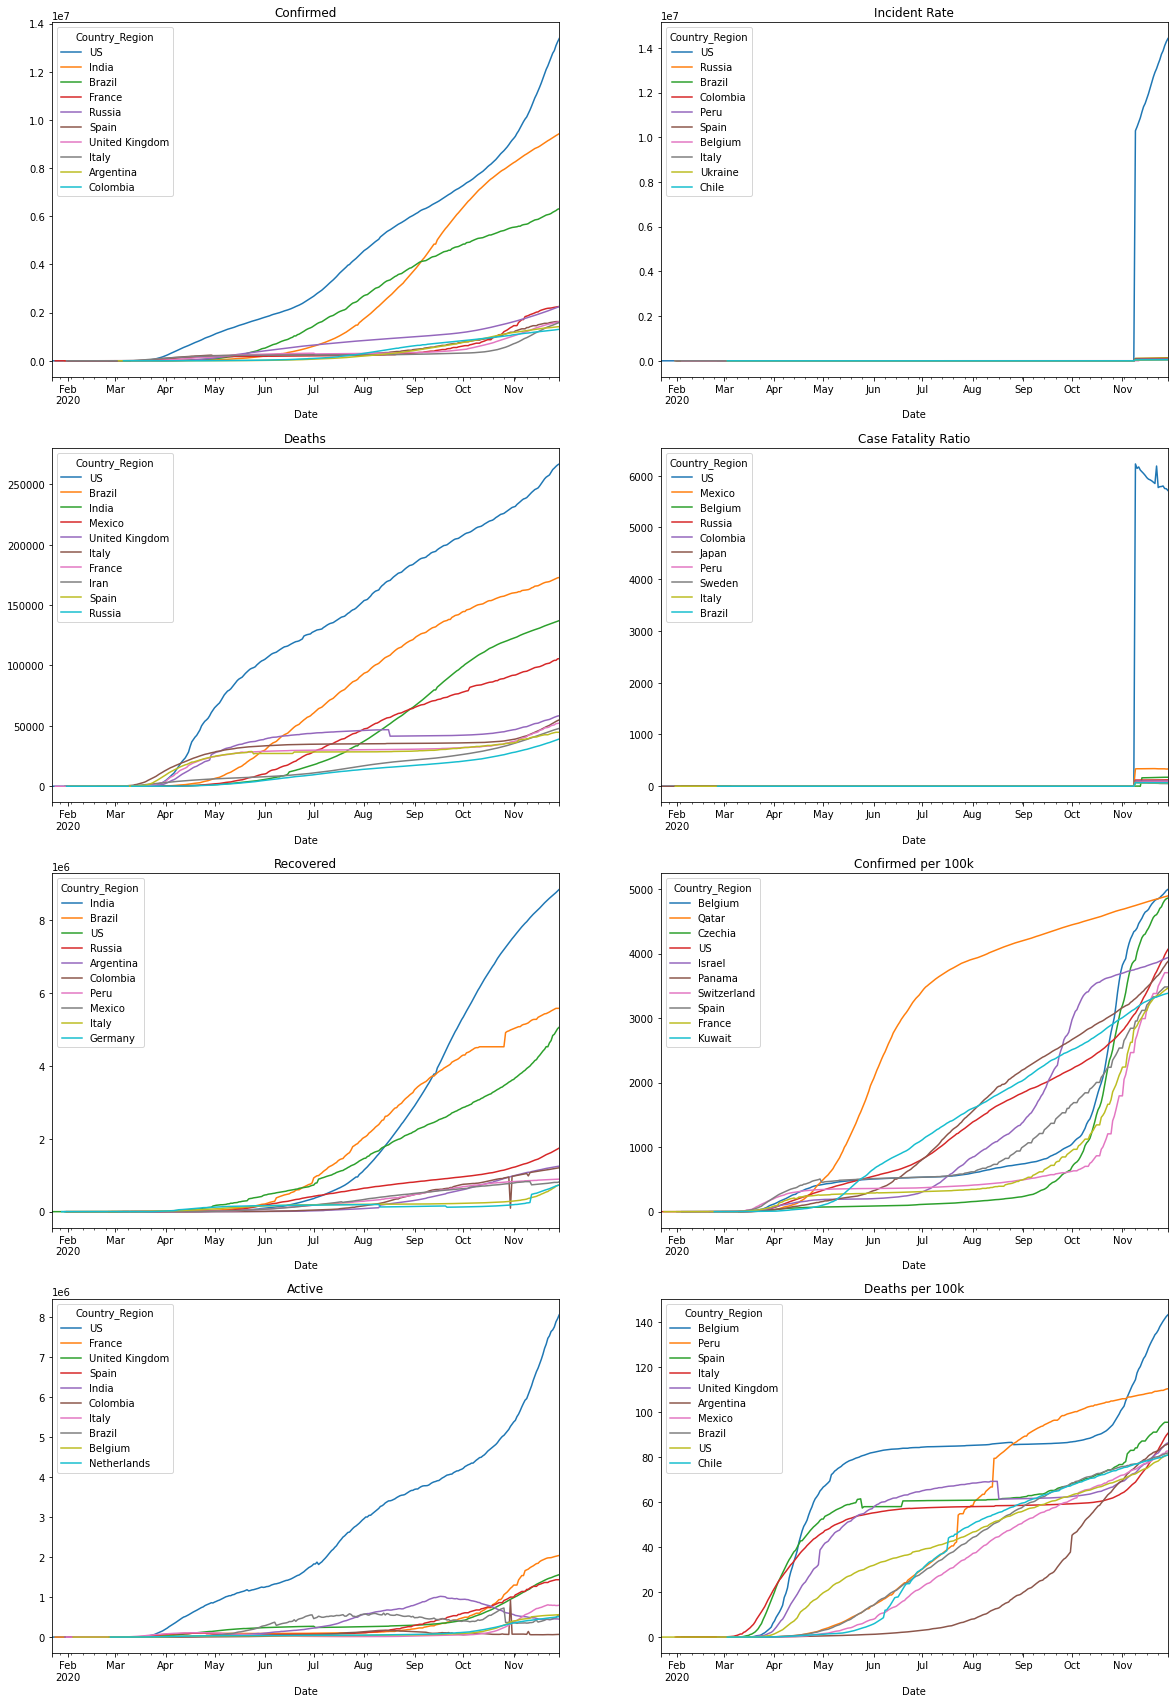

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

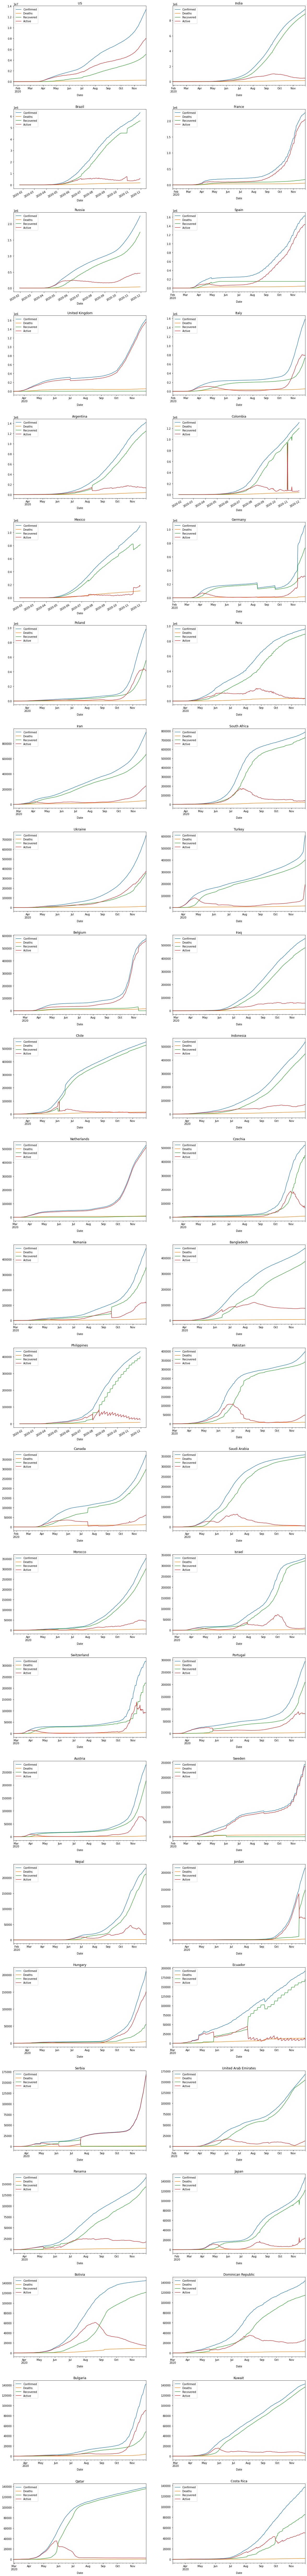

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-11-25    16731.6   449.8       37.0   
                              2020-11-26    16258.8   481.4       28.8   
                              2020-11-27    15489.6   505.6       28.0   
                              2020-11-28    15574.8   560.0       33.4   
                              2020-11-29    15738.8   481.4       21.8   

                                           Active  Incident_Rate  \
Country_Region Country_Region Date                                 
Argentina      Argentina      2020-03-03      NaN            NaN   
                              2020-03-04      NaN            NaN   
                              2020-03-05      NaN            NaN   
                              2020-03-06      NaN            NaN   
                              2020-03-07      NaN            NaN   
...                                           ...            ...   
United Kingdom United Kingdom 2020-11-25  16244.8     141.004791   
                              2020-11-26  15748.6     125.703139   
                              2020-11-27  14956.0     138.467873   
                              2020-11-28  14981.4     142.707653   
                              2020-11-29  15235.6     140.303594   

                                          Case_Fatality_Ratio  \
Country_Region Country_Region Date                              
Argentina      Argentina      2020-03-03                  NaN   
                              2020-03-04                  NaN   
                              2020-03-05                  NaN   
                              2020-03-06                  NaN   
                              2020-03-07                  NaN   
...                                                       ...   
United Kingdom United Kingdom 2020-11-25            -0.093701   
                              2020-11-26            -0.080861   
                              2020-11-27            -0.144365   
                              2020-11-28            -0.159572   
                              2020-11-29            -0.169272   

                                          Confirmed_per_100k  Deaths_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03                 NaN              NaN   
                              2020-03-04                 NaN              NaN   
                              2020-03-05                 NaN              NaN   
                              2020-03-06                 NaN              NaN   
                              2020-03-07                 NaN              NaN   
...                                                      ...              ...   
United Kingdom United Kingdom 2020-11-25           24.776485         0.666073   
                              2020-11-26           24.076353         0.712867   
                              2020-11-27           22.937306         0.748702   
                              2020-11-28           23.063472         0.829259   
                              2020-11-29           23.306327         0.712867   

                                          Recovered_per_100k  Active_per_100k  
Country_Region Country_Region Date                                             
Argentina      Argentina      2020-03-03                 NaN              NaN  
                              2020-03-04              

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-03-03        NaN     NaN        NaN      NaN   
               2020-03-04        NaN     NaN        NaN      NaN   
               2020-03-05        NaN     NaN        NaN      NaN   
               2020-03-06        NaN     NaN        NaN      NaN   
               2020-03-07        NaN     NaN        NaN      NaN   
...                              ...     ...        ...      ...   
United Kingdom 2020-11-25    16731.6   449.8       37.0  16244.8   
               2020-11-26    16258.8   481.4       28.8  15748.6   
               2020-11-27    15489.6   505.6       28.0  14956.0   
               2020-11-28    15574.8   560.0       33.4  14981.4   
               2020-11-29    15738.8   481.4       21.8  15235.6   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-03-03            NaN                  NaN   
               2020-03-04            NaN                  NaN   
               2020-03-05            NaN                  NaN   
               2020-03-06            NaN                  NaN   
               2020-03-07            NaN                  NaN   
...                                  ...                  ...   
United Kingdom 2020-11-25     141.004791            -0.093701   
               2020-11-26     125.703139            -0.080861   
               2020-11-27     138.467873            -0.144365   
               2020-11-28     142.707653            -0.159572   
               2020-11-29     140.303594            -0.169272   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-11-25           24.776485         0.666073   
               2020-11-26           24.076353         0.712867   
               2020-11-27           22.937306         0.748702   
               2020-11-28           23.063472         0.829259   
               2020-11-29           23.306327         0.712867   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-11-25            0.054790        24.055622  
               2020-11-26            0.042648        23.320839  
               2020-11-27            0.041463        22.147141  
               2020-11-28            0.049459        22.184754  
               2020-11-29            0.032282        22.561178  

[14117 rows x 10 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

272

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-11-25     6269.2   184.8     7893.0 -1808.6   
               2020-11-26     6649.8   207.8     7921.8 -1479.8   
               2020-11-27     7382.2   242.8     7953.0  -813.6   
               2020-11-28     7748.8   240.0     7815.4  -306.6   
               2020-11-29     7402.4   208.2     7841.8  -647.6   
Austria        2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
               2020-02-29        NaN     NaN        NaN     NaN   
               2020-03-01        2.4     0.0        0.0     2.4   
               2020-03-02        3.2     0.0        0.0     3.2   
               2020-03-03        3.6     0.0        0.0     3.6   
               2020-03-04        5.2     0.0        0.0     5.2   
               2020-03-05        6.4     0.0        0.0     6.4   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-11-25      13.871207             0.001085   
               2020-11-26      14.713322             0.002014   
               2020-11-27      16.333827             0.003089   
               2020-11-28      17.144965             0.002175   
               2020-11-29      16.378521             0.000541   
Austria        2020-02-25            NaN                  NaN   
               2020-02-26            NaN                  NaN   
               2020-02-27            NaN                  NaN   
               2020-02-28            NaN                  NaN   
               2020-02-29            NaN                  NaN   
               2020-03-01       0.000000             0.000000   
               2020-03-02       0.000000             0.000000   
               2020-03-03       0.000000             0.000000   
               2020-03-04       0.000000             0.000000   
               2020-03-05       0.000000             0.000000   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-11-25           13.999789         0.412678   
               2020-11-26           14.849709         0.464039   
               2020-11-27           16.485236         0.542198   
               2020-11-28           17.303893         0.535945   
               2020-11-29           16.530345         0.464933   
Austria        2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29                 NaN              NaN   
               2020-03-01            0.026800         0.000000   
               2020-03-02            0.035734         0.000000   
               2020-03-03            0.040201         0.000000   
               2020-03-04            0.058067         0.000000   
               2020-03-05            0.071468         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-11-25           17.625907        -4.038796  
               2020-11-26           17.690220        -3.304550  
               2020-11-27           17.759893        -1.816855  
               2020-11-28           17.452618        -0.684670  
               2020-11-29           17.511572        -1.446160  
Austria        2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
        

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-05-22            0.0                  0.0   
               2020-05-23            0.0                  0.0   
               2020-05-24            0.0                  0.0   
               2020-05-25            0.0                  0.0   
               2020-05-26            0.0                  0.0   
               2020-05-27            0.0                  0.0   
               2020-05-28            0.0                  0.0   
               2020-05-29            0.0                  0.0   
               2020-05-30            0.0                  0.0   
               2020-05-31            0.0                  0.0   
               2020-06-01            0.0                  0.0   
               2020-06-02            0.0                  0.0   
               2020-06-03            0.0                  0.0   
               2020-06-04            0.0                  0.0   
               2020-06-05            0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112  

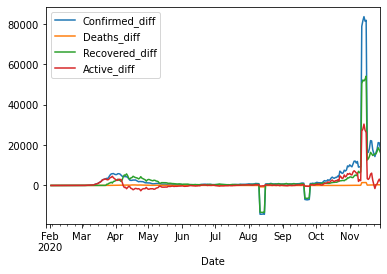

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

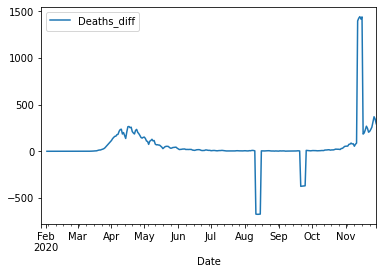

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

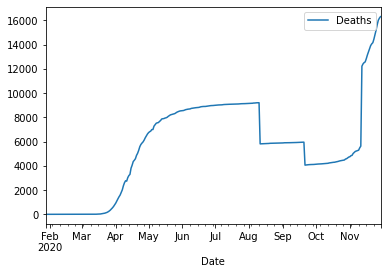

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

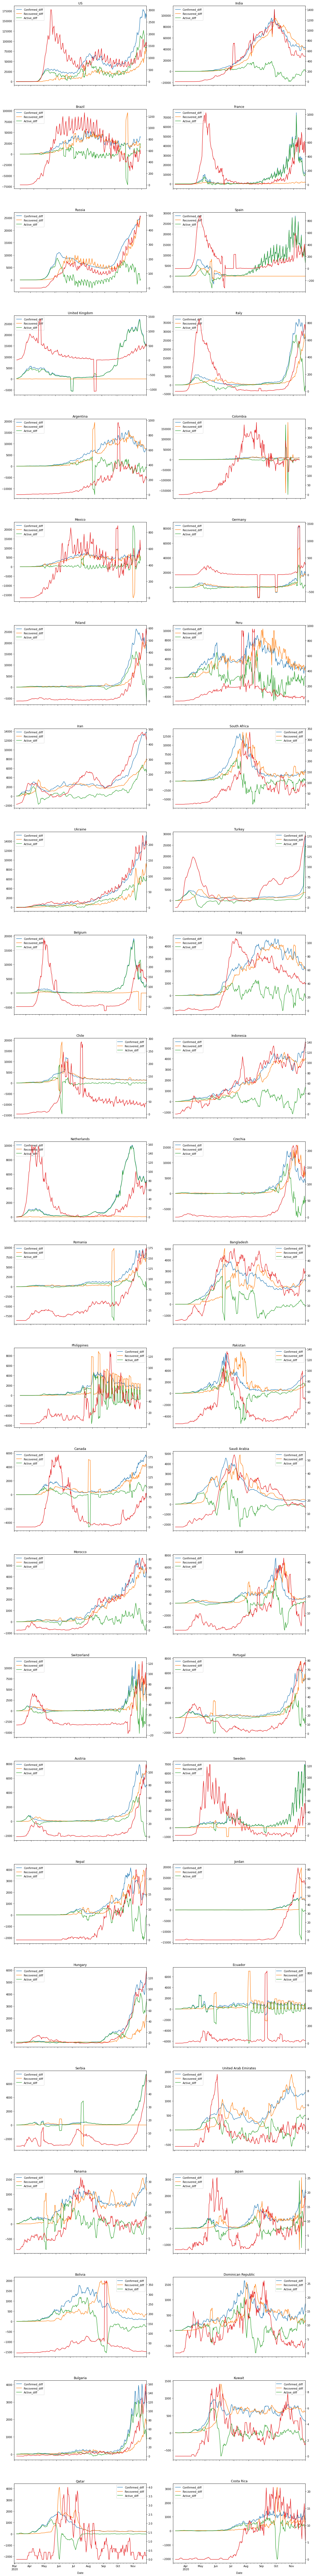

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50